<a href="https://colab.research.google.com/github/RR77ui/Business-Intelligence/blob/main/Integracion%20de%20Datos%20y%20Prospectiva/Parcial1_JuanRave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Caso de Estudio**
Una entidad del sector salud en Colombia, quiere llevar a cabo un estudio
sobre los hábitos de las personas y que las pueden llevar a tener riesgo de ataque cardiaco en América, para esto se cuenta con una base datos que tiene categorias para predecir el riesgo de ataque cardiaco en pacientes con 26 variables y 8763 registros.
Para este caso se realizaran una caracterizacion de la variable mas importante (La variable con mayor correlacion) con respecto a la variable a pronosticar(Riesgo de ataque cardiaco), ademas se medira la credibilidad de los paises de america para ver cual se acerca mas a los datos de colombia y de esta manera integrar los 2 paises con mayor credibilidad y por ultimo alcanzar un confiabilidad del 99,9%.

0. Cargar librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew,kurtosis

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Se carga el dataset y se determina la correlacion de las variables

In [2]:
path='/content/drive/MyDrive/Integración de datos y prospectiva/heart_attack_prediction_dataset.csv'
df=pd.read_csv(path)
#df.info()
#Convertir la categoria sex a Booleano o Binario (0=Male, 1=Female)
df['Sex'] = df['Sex'].map({'Male': 0, 'Female': 1})

#Convertir la categoria dieta y consumo de alcohol en una columna por cada una de las categorias que contiene
df = pd.get_dummies(df, columns=['Diet'], prefix='Diet', dtype=int)
df = pd.get_dummies(df, columns=['Alcohol Consumption'], prefix='Alcohol', dtype=int)

#Dividir la categoria presion en los 2 tipo de presion y convertirlos en enteros
df[['Systolic Pressure', 'Diastolic Pressure']] = df['Blood Pressure'].str.split('/', expand=True)
df['Systolic Pressure'] = pd.to_numeric(df['Systolic Pressure'], errors='coerce')
df['Diastolic Pressure'] = pd.to_numeric(df['Diastolic Pressure'], errors='coerce')

#Crear data frame que no contenga las variables que son strings o textos
df_corr = df.drop(['Patient ID', 'Blood Pressure', 'Country', 'Continent', 'Hemisphere'], axis=1)


#Matriz de correlacion
matriz_corr = df_corr.corr()

#Print de la matriz
heart_attack_corr = matriz_corr['Heart Attack Risk']
display("Correlacion de las variables con Heart attack:")
display(heart_attack_corr.sort_values(ascending=False)) #Variable escogida Cholesterol

'Correlacion de las variables con Heart attack:'

,Heart Attack Risk
Heart Attack Risk,1.000000
Cholesterol,0.019340
Systolic Pressure,0.018585
Diabetes,0.017225
Alcohol_0,0.013778
Exercise Hours Per Week,0.011133
Triglycerides,0.010471
Income,0.009628
Diet_Healthy,0.009409
Age,0.006403


In [3]:
# @title  Método: Estimacion de Credibilidad
# Variables de Entrada: Dataset de observacion Colombia(XDo)
# Variables de Salida: Factor de credibilidad y Credibilidad(fc,Cr)
def credibilidad(XDo,XDe):

  # Se calcula el valor esperado de la varianza
  NDo=len(XDo); NDe=len(XDe)
  EPV=(NDo*np.var(XDo)+NDe*np.var(XDe))/(NDo+NDe)

  # Valor Hipotetico de la media (Es la media compartida)
  uh=(NDo*np.mean(XDo)+NDe*np.mean(XDe))/(NDo+NDe)

  # Varianza Hipotetica de la media (Varianza del total de los datos con respecto a la media compartida)
  VHM=((NDo*np.mean(XDo)**2+NDe*np.mean(XDe)**2)/(NDo+NDe))-uh**2

  #Factor de credibilidad
  fc=(EPV/VHM)

  #La credibilidad es
  Cr=NDo/(NDo+fc)

  return fc,Cr

2. Definir La credibilidad de los paises de America con respecto a Colombia

In [4]:
#Datos Observados (XDo)
XDo = df[df['Country'] == 'Colombia'].copy()

#Datos para integracion
america = ['Argentina', 'Brazil', 'Canada', 'United States']

#Almacen de datos de credibilidad
lista_Credibilidad = []

#Ciclo para calcular la credibilidad de cada uno de los paises
for country in america:
  XDe = df[df['Country'] == country].copy()
  if not XDe.empty:
    fc, Cr = credibilidad(XDo['Cholesterol'], XDe['Cholesterol'])
    lista_Credibilidad.append({'Country': country, 'Factor de credibilidad (fc)': fc, 'Credibilidad (Cr)': Cr})



credibility_df = pd.DataFrame(lista_Credibilidad)
display("Resultados de Factor y Credibilidad:")
display(credibility_df) #Paises escogidos United States y Canada

'Resultados de Factor y Credibilidad:'

,Country,Factor de credibilidad (fc),Credibilidad (Cr)
0,Argentina,256105.241460,0.001672
1,Brazil,1276.764388,0.251500
2,Canada,1022.110357,0.295636
3,United States,533.682936,0.445630


In [5]:
#Filtrado de paises escogidos
XDe_us_cn = df[df['Country'].isin(['United States', 'Canada'])].copy()
XDe_us_cn = XDe_us_cn['Cholesterol']
XDo = df[df['Country'] == 'Colombia'].copy()
XDo = XDo['Cholesterol']
#Convertir los dataframes en arrays
XDe_us_cn = np.array(XDe_us_cn)
XDo = np.array(XDo)

In [6]:
uo=np.mean(XDo);uf1=np.mean(XDe_us_cn)
sigmao=np.std(XDo);sigmaf1=np.std(XDe_us_cn)

#Se procede con la integracion
XDint=[]#Dataset con todos los datos integrados
for k in  range(len(XDe_us_cn)):
  print(XDe_us_cn[k])
  x=XDe_us_cn[k] #Dato a integrar
  VPo=np.exp(-0.5*((x-uo)/sigmao)**2)
  VPus_cn=np.exp(-0.5*((x-uf1)/sigmaf1)**2)

  if VPus_cn<VPo and VPo>0.9: #0.9 asegura que los datos sean confiables con respecto a los datos observados
    XDint.append(x)#Rellena XDint con los valores que cumplan la condicion
    print("El dato de integracion esta en la fila:",k)
  else:
    print("El dato de integracion no se integra")


389
El dato de integracion no se integra
383
El dato de integracion no se integra
358
El dato de integracion no se integra
374
El dato de integracion no se integra
303
El dato de integracion no se integra
145
El dato de integracion no se integra
340
El dato de integracion no se integra
133
El dato de integracion no se integra
129
El dato de integracion no se integra
251
El dato de integracion esta en la fila: 9
121
El dato de integracion no se integra
243
El dato de integracion esta en la fila: 11
133
El dato de integracion no se integra
203
El dato de integracion no se integra
248
El dato de integracion esta en la fila: 14
291
El dato de integracion no se integra
173
El dato de integracion no se integra
396
El dato de integracion no se integra
251
El dato de integracion esta en la fila: 18
148
El dato de integracion no se integra
232
El dato de integracion esta en la fila: 20
152
El dato de integracion no se integra
302
El dato de integracion no se integra
188
El dato de integracion n

3. Integracion de los datos USA y Canada

In [7]:
XDo=np.array(XDo).reshape(-1,1)  #Quitar la estructura del array
XDe_us_cn=np.array(XDe_us_cn).reshape(-1,1) ##Quitar la estructura del array
XDint = np.array(XDint).reshape(-1,1) #Quitar la estructura del array

XDT=np.concatenate((XDo,XDint),axis=0) #Base de datos total con los datos integrados
nint=len(XDT)-len(XDo)#Numero de datos integrados

#Evaluamos las metricas
print("el numero de datos integrados es:",nint)
print("Numero de datos de la base datos total es:",len(XDT))
print("la media observados:",np.mean(XDo))
print("la media integrado:",np.mean(XDT))
print("la varianza observados:",np.var(XDo))
print("la varianza integrado:",np.var(XDT))
print("la desviacion observados:",np.std(XDo))
print("la desviacion integrado:",np.std(XDT))
print("El coefienciente de asimetria observados:",skew(XDo))
print("El coefienciente de asimetria integrado:",skew(XDT))
print("El coefienciente de curtosis observados:",kurtosis(XDo))
print("El coefienciente de curtosis integrado:",kurtosis(XDT))

el numero de datos integrados es: 137
Numero de datos de la base datos total es: 566
la media observados: 261.84615384615387
la media integrado: 257.41519434628975
la varianza observados: 6592.232741617357
la varianza integrado: 5086.762242630075
la desviacion observados: 81.19256580264819
la desviacion integrado: 71.32154122444408
El coefienciente de asimetria observados: [0.02843347]
El coefienciente de asimetria integrado: [0.20993915]
El coefienciente de curtosis observados: [-1.17165749]
El coefienciente de curtosis integrado: [-0.64000381]


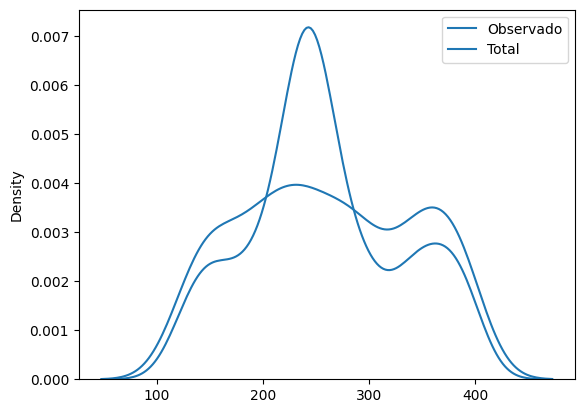

In [22]:
plt.figure()
sns.kdeplot(XDo, label='Observado', color='red')
sns.kdeplot(XDT, label='Total', color='blue')
plt.legend()
plt.show()

4. Llegar a confiabilidad del 99,99%

In [15]:
# @title Método: Histograma de Frecuencias
# Variables de Entrada: Base de datos total (XDT)
# Variables de Salida: Limite Inferior, Limite Superior, Número de Datos
def Histx(XDT): #Nombre de su método

  NC=10  #Número de Clusters

  plt.figure()
  sns.histplot(XDT,kde=True,bins=NC,color='red')
  plt.title('Distribución Total')
  plt.show()

  #Obtenemos la información de la Distribución
  counts, bin_edges=np.histogram(XDT,bins=NC)
  LI=bin_edges[:-1];LS=bin_edges[1:]
  mc=(LI+LS)/2 #El valor representativo de cada intervalo
  freq=counts/np.sum(counts)

  return LI,LS,counts,mc,freq

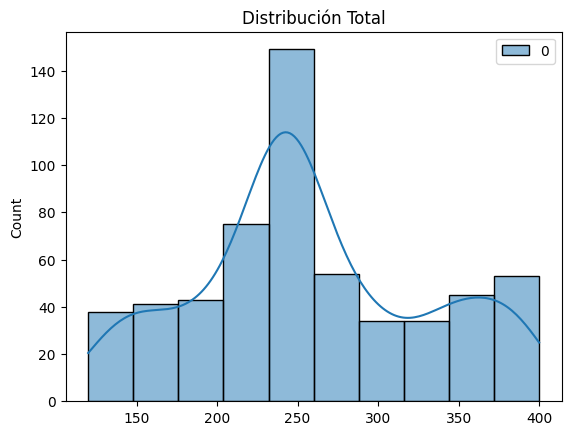

1000


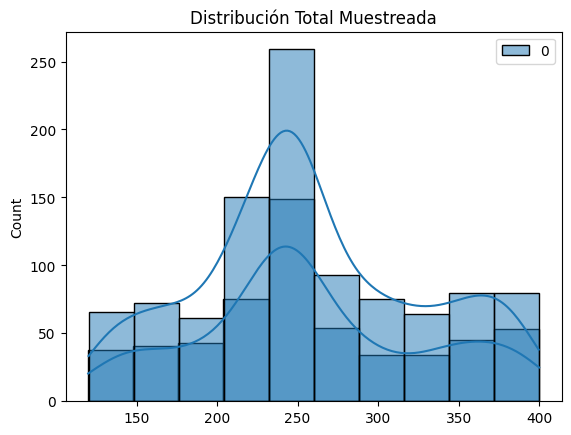

In [16]:
LI,LS,counts,mc,freq=Histx(XDT)
acum=np.cumsum(freq)
Confiabilidad=999+1 #Confiabilidad del 99.99%
print(Confiabilidad)
XDTM=np.zeros((Confiabilidad,1))#Variable Muestreada, El np crea una tabla de una sola columna

for k in range(Confiabilidad):
 al=np.random.uniform(0,1) #Numero aletario entre 0 y 1
 inter=np.where(al<=acum)[0][0] #Define en que intervalo queda
 #print("Limite Inferior:",LI[inter])
 #print("Limite Superior:",LS[inter])
 XDTM[k]=np.random.uniform(LI[inter],LS[inter]) #Muestra aleatoria dentro del intervalo
 #print("El numero seleccionado es:",LDAm[k])

plt.figure()
sns.histplot(XDT,kde=True,bins=10,color='red')
sns.histplot(XDTM,kde=True,bins=10,color='red')
plt.title('Distribución Total Muestreada')
plt.show()

In [13]:
#Comparacion de metricas

#Base de datos total(XDT)
print("informacion Base de datos total")
print("la media es:",np.mean(XDT))
print("la varianza es:",np.var(XDT))
print("la desviacion estandar es:",np.std(XDT))
print("la coeficiente de asimetria es:",skew(XDT))
print("la coeficiente de curtosis es:",kurtosis(XDT))
#Base de datos Muestreada
print("informacion Base total integrada")
print("la media es:",np.mean(XDTM))
print("la varianza es:",np.var(XDTM))
print("la desviacion estandar es:",np.std(XDTM))
print("la coeficiente de asimetria es:",skew(XDTM))
print("la coeficiente de curtosis es:",kurtosis(XDTM))

#Diferencias entre las metricas
dif_u=(np.mean(XDT)-np.mean(XDTM))/np.mean(XDT)
print("la diferencia porcentual de la media es:",dif_u*100)
dif_v=(np.var(XDT)-np.var(XDTM))/np.var(XDT)
print("la diferencia porcentual de la varianza es:",dif_v*100)
dif_s=(np.std(XDT)-np.std(XDTM))/np.std(XDT)
print("la diferencia porcentual de la desviacion estandar es:",dif_s*100)
dif_a=(skew(XDT)-skew(XDTM))/skew(XDT)
print("la diferencia porcentual de la asimetria es:",dif_a*100)
dif_k=(kurtosis(XDT)-kurtosis(XDTM))/kurtosis(XDT)
print("la diferencia porcentual de la curtosis es:",dif_k*100)

informacion Base de datos total
la media es: 257.41519434628975
la varianza es: 5086.762242630075
la desviacion estandar es: 71.32154122444408
la coeficiente de asimetria es: [0.20993915]
la coeficiente de curtosis es: [-0.64000381]
informacion Base total integrada
la media es: 259.7386973998987
la varianza es: 5019.961389281353
la desviacion estandar es: 70.851685860545
la coeficiente de asimetria es: [0.18778064]
la coeficiente de curtosis es: [-0.71258773]
la diferencia porcentual de la media es: -0.9026285567600261
la diferencia porcentual de la varianza es: 1.3132293227485883
la diferencia porcentual de la desviacion estandar es: 0.6587846474327701
la diferencia porcentual de la asimetria es: [10.55473241]
la diferencia porcentual de la curtosis es: [-11.34116918]


In [23]:
XDTM=pd.DataFrame(XDTM)
XDTM.describe()

,0
count,1000.000000
mean,257.320324
std,69.760902
min,120.237765
25%,213.119188
50%,249.040789
75%,305.877484
max,399.730732


##**Analisis de Resultados**
Este analisis constara de las cuatro fases realizadas en el codigo para cumplir con lo explicado en el caso de estudio.

1. Se cargaron los datos, se modificaron algunas variables como sex,blood pressure,diet y alcohol consumption para poder obtener su correlacion respecto a Heart attack risk, donde se encontro que la variable Cholesterol es la de mayor correlacion, por lo cual se selecciono para utilizarla como varaible de integracion.

2. Se lleva a cabo un proceso para definir los paises de america con mayor credibilidad para poder integrar con colombia, para esto se realizo un division de los dataset filtrando en principio en el objeto XDo los registros de colombia que sera la base de datos observada, creando un ciclo para el calculo de la credibilidad de los paises de america con solo la columna o varaible de integracion Cholesterol que se almacenaron en list de credibilidad. Con esto obtuvimos como resultado que los paises con mayor credibilidad respecto a colombia eran United States y Canada con un 44% y 29% de credibilidad respectivamente

3. Luego se realiza el filtrado de los paises escogidos con su la variable de integracion para luego calcular los datos se van a integrar utilizando el metodo de aceptacion y rechazo donde se encuentra que con una confiabilidad del 90% en los datos integrados se aceptaron 137 datos(XDint) para la integracion y se obtuvo una base de datos total (XDT) de 566 registros ademas se analizo la distribucion de los datos observados(XDo) y la base de datos total para que tuvieran las mismas medidas de tendencia central y dispersion las cuales fueron muy parecidas lo que se puede ver en tanto el histograma como en el grafico de lineas donde se ve que las colas de la distribucion se mantiene pero los datos estan mucho mas agrupados en la media pero sin afectar la distribucion original

4. Por ultimo se necesitaba llegar a una confiabilidad de los datos del 99,9% por lo que se realizo un muestro aletorio con el metodo de montecarlo y se realizo nuevamente una comparacion de las medidas de tendencia central y dispersion donde se encontro que antes y despues del muestreo las metricas tuvieron las siguientes diferencias: La media tuvo una diferencia del -0,9%, la varianza del 1,31%, la desviacion estandar del 0,65%, el coeficiente de asimetria del 10,55% y el coeficiente de asimetria del -11,34% mostrando un desempeño adecuado y manteniendo las medidas con variaciones en niveles normales de menores al 5% en el caso de las medidas de tendencia central y menores al 15% en el caso de las medidas de dispersion.